<a href="https://colab.research.google.com/github/MichaelCusackNelkin/DATA_410/blob/main/Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Video Classification Using Hypertuned  CNN-RNN Architectures

## Below is preparing to try out video classifcation on one video
Many methods are from this notebook: https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/video_classification.ipynb

Some video reading adopted from here: https://www.kaggle.com/kmader/drone-flight-path/notebook

Data from here: https://www.kaggle.com/datasets/aryashah2k/highway-traffic-videos-dataset?resource=download

Audio classification from here: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb

When this is applied later to idleing trucks, I will likely switch to pure CNNs, and also add a text processor.

In [ ]:
import os
from glob import glob
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from IPython.display import display
#VIDEO_DIR = os.path.join('..', 'input', 'highway-traffic-videos-dataset', 'video' )
VIDEO_DIR = ''
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
def read_video_segment(in_path, vid_seg = None):
    cap = cv.VideoCapture(in_path)
    video_length = int(cap.get(cv.CAP_PROP_FRAME_COUNT)) - 1
    frames = []
    if cap.isOpened() and video_length > 0:
        frame_ids = [0]
        if vid_seg is None:
            vid_seg = np.array([0, 0.25, 0.5, 0.75, 1])
        else:
            vid_seg = np.clip(vid_seg, 0, 1)
            
        frame_ids = np.clip(video_length*vid_seg, 0, video_length-1).astype(int)
        count = 0
        success, image = cap.read()
        print('Loaded', video_length, 'frames at', image.shape, 'resolution')
        while success:
            if count in frame_ids:
                frames.append(image)
            success, image = cap.read()
            count += 1
    return frames

Loaded 52 frames at (240, 320, 3) resolution


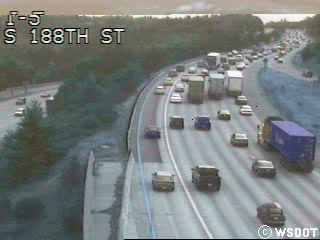

In [ ]:
frames = read_video_segment('/content/drive/MyDrive/DATA410_Final_Project/videos/cctv052x2004080516x01638.avi')
img = frames[0]
out_image = cv.cvtColor(img, cv.COLOR_BGR2RGB)
display(Image.fromarray(img))

In [ ]:
!pip install git+https://github.com/tensorflow/docs
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths
from sklearn.model_selection import train_test_split as tts

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

!pip install -q -U keras-tuner
import keras_tuner as kt

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-fga7eskr
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-fga7eskr
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=179891 sha256=91cc7e3889ad652b39bb56a1c5f049d0017bd6185a3581c24268cf122a26d91b
  Stored in directory: /tmp/pip-ephem-wheel-cache-sg_myef4/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs
     |████████████████████████████████| 133 kB 4.3 MB/s 


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/DATA410_Final_Project/info.txt', sep='\t')

train_df, test_df = tts(data, stratify = data['class'], test_size=0.2, train_size=0.8, random_state=1239, shuffle=True)
train_df, test_df = train_df[['# filename', 'class']], test_df[['# filename', 'class']]

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")
display(train_df.head(3))
print('\n The class counts are: ' + str(data.value_counts('class'))) # Big class imbalance

print('\n The training class counts are: ' + str(train_df.value_counts('class')))
print('\n The testing class counts are: ' + str(test_df.value_counts('class')))

Total videos for training: 203
Total videos for testing: 51


,# filename,class
2,cctv052x2004080516x01640,light
215,cctv052x2004080617x00066,heavy
66,cctv052x2004080606x01826,light



 The class counts are: class
light     165
medium     45
heavy      44
dtype: int64

 The training class counts are: class
light     132
medium     36
heavy      35
dtype: int64

 The testing class counts are: class
light     33
heavy      9
medium     9
dtype: int64


In [ ]:
IMG_SIZE = 220
BATCH_SIZE = 5
EPOCHS = 100

MAX_SEQ_LENGTH = 36
NUM_FEATURES = 2048

#DIR = "testing\\"
DIR = "/content/drive/MyDrive/DATA410_Final_Project/videos/"
#DIR = ""

In [ ]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

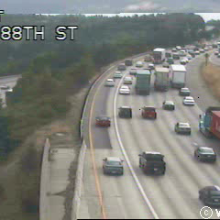

In [ ]:
frames = load_video('/content/drive/MyDrive/DATA410_Final_Project/videos/cctv052x2004080516x01638.avi')
img = frames[0]
out_image = cv.cvtColor(img, cv.COLOR_BGR2RGB)
display(Image.fromarray(img))

In [ ]:
#Feature extraction with the INception V3 Model
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()

87924736/87910968 [==============================] - 0s 0us/step


We need to make the labels into a numerical format. Using a string-lookup layer

In [ ]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["class"]))

print(label_processor.get_vocabulary())

['heavy', 'light', 'medium']


In [ ]:
def prepare_all_videos(df, root_DIR):
    num_samples = len(df)
    video_paths = df["# filename"].values.tolist()
    labels = df["class"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(root_DIR + path + '.avi', max_frames=50)
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [ ]:
train_data, train_labels = prepare_all_videos(train_df, DIR)
test_data, test_labels = prepare_all_videos(test_df, DIR)
kfold_data, kfold_labels = prepare_all_videos(data[['# filename','class']], DIR)
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")
print(f"Frame features in kfold set: {kfold_data[0].shape}")
print(f"Frame masks in kfold set: {kfold_data[1].shape}")

Frame features in train set: (203, 36, 2048)
Frame masks in train set: (203, 36)
Frame features in test set: (51, 36, 2048)
Frame masks in test set: (51, 36)
Frame features in kfold set: (254, 36, 2048)
Frame masks in kfold set: (254, 36)


In [ ]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return rnn_model

# Utility for running experiments. This only trains the model once. It does not pick the best version of itself during training.
def run_experiment(train_data,train_labels,test_data,test_labels, filepath):
    #saves the classifier
    #checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, verbose=0)

    seq_model = get_sequence_model()
    history = seq_model.fit(train_data, train_labels, validation_split=0.2, epochs=EPOCHS,verbose=0)

    #seq_model=tf.keras.models.load_model(filepath)
    _, accuracy = seq_model.evaluate(test_data, test_labels, verbose=0)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model, accuracy

In [ ]:
def get_hypertuned_model(hp):
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(units=hp.Int(name='GRU_1', min_value=12, max_value=24, step=2),
                         return_sequences=True)(frame_features_input, mask=mask_input)
    x = keras.layers.GRU(units=hp.Int(name='GRU_2', min_value=2, max_value=12, step=2))(x)

    #Now dense/dropouts
    x = keras.layers.Dropout(rate=hp.Float(name='dropout_rate', min_value=0.2, max_value=0.4, step=0.1))(x)
    x = keras.layers.Dense(units=hp.Int(name='dense_1', min_value=4, max_value=12, step=2), 
                           activation="relu")(x)

    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)
    rnn_model.compile(loss="sparse_categorical_crossentropy", 
                      optimizer=keras.optimizers.Adam(), metrics=["accuracy"])
    return rnn_model

In [ ]:
tuner_name='Tuner_5'
tuner = kt.Hyperband(get_hypertuned_model,
                     objective='val_loss',
                     max_epochs=100,
                     factor=3,
                     directory='/content/drive/MyDrive/DATA410_Final_Project/Tuners',
                     project_name=tuner_name)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(train_data,train_labels, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in each layer, in-order, is 
{best_hps.get('GRU_1')} {best_hps.get('GRU_2')} {best_hps.get('dropout_rate')} {best_hps.get('dense_1')}
and the optimal learning rate for the optimizer
is 0.001.
""")

INFO:tensorflow:Reloading Oracle from existing project /content/drive/MyDrive/DATA410_Final_Project/Tuners/Tuner_5/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/MyDrive/DATA410_Final_Project/Tuners/Tuner_5/tuner0.json
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in each layer, in-order, is 
18 10 0.4000000000000001 8
and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 100 epochs
model = tuner.hypermodel.build(best_hps)

history = model.fit(train_data, train_labels, validation_split=0.2, epochs=EPOCHS,verbose=1)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
6/6 [==============================] - 10s 434ms/step - loss: 0.9100 - accuracy: 0.6111 - val_loss: 0.7865 - val_accuracy: 0.6098
Epoch 2/100
6/6 [==============================] - 0s 19ms/step - loss: 0.7943 - accuracy: 0.6914 - val_loss: 0.7287 - val_accuracy: 0.6098
Epoch 3/100
6/6 [==============================] - 0s 18ms/step - loss: 0.7233 - accuracy: 0.7469 - val_loss: 0.6797 - val_accuracy: 0.6341
Epoch 4/100
6/6 [==============================] - 0s 19ms/step - loss: 0.6269 - accuracy: 0.7346 - val_loss: 0.5517 - val_accuracy: 0.7805
Epoch 5/100
6/6 [==============================] - 0s 19ms/step - loss: 0.5265 - accuracy: 0.8765 - val_loss: 0.5796 - val_accuracy: 0.6829
Epoch 6/100
6/6 [==============================] - 0s 19ms/step - loss: 0.5220 - accuracy: 0.8272 - val_loss: 0.5750 - val_accuracy: 0.7073
Epoch 7/100
6/6 [==============================] - 0s 19ms/step - loss: 0.4782 - accuracy: 0.8395 - val_loss: 0.4594 - val_accuracy: 0.8049
Epoch 8/100
6/6 [=

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)
tuned_model_name='Tuned_model_5.h5'
filepath = "/content/drive/MyDrive/DATA410_Final_Project/Tuned_Models/" + tuned_model_name

# Retrain the model with optimal number of epochs from above (prevents overfitting)
hyper_checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, verbose=0)
hypermodel.fit(train_data, train_labels, validation_split=0.2, epochs=best_epoch, callbacks=[hyper_checkpoint],verbose=1)

_, accuracy = hypermodel.evaluate(test_data, test_labels)
print(f"[Test accuracy]: {round(accuracy * 100, 2)}%")

Epoch 1/51
6/6 [==============================] - 10s 707ms/step - loss: 1.0380 - accuracy: 0.4938 - val_loss: 0.9785 - val_accuracy: 0.6098
Epoch 2/51
6/6 [==============================] - 0s 28ms/step - loss: 0.9810 - accuracy: 0.5802 - val_loss: 0.9631 - val_accuracy: 0.6098
Epoch 3/51
6/6 [==============================] - 0s 27ms/step - loss: 0.9763 - accuracy: 0.5988 - val_loss: 0.9461 - val_accuracy: 0.6098
Epoch 4/51
6/6 [==============================] - 0s 27ms/step - loss: 0.9567 - accuracy: 0.5988 - val_loss: 0.9374 - val_accuracy: 0.6098
Epoch 5/51
6/6 [==============================] - 0s 28ms/step - loss: 0.8810 - accuracy: 0.6605 - val_loss: 0.8700 - val_accuracy: 0.6098
Epoch 6/51
6/6 [==============================] - 0s 28ms/step - loss: 0.8649 - accuracy: 0.5864 - val_loss: 0.8223 - val_accuracy: 0.6098
Epoch 7/51
6/6 [==============================] - 0s 30ms/step - loss: 0.7859 - accuracy: 0.6481 - val_loss: 0.7640 - val_accuracy: 0.6098
Epoch 8/51
6/6 [=========

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_tuned_model = tf.keras.models.load_model("/content/drive/MyDrive/DATA410_Final_Project/Tuned_Models/" + tuned_model_name)

# Show the model architecture
new_tuned_model.summary()

_, accuracy = new_tuned_model.evaluate(test_data, test_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 36, 2048)]   0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 36)]         0           []                               
                                                                                                  
 gru_4 (GRU)                    (None, 36, 18)       111672      ['input_7[0][0]',                
                                                                  'input_8[0][0]']                
                                                                                                  
 gru_5 (GRU)                    (None, 10)           900         ['gru_4[0][0]']            

In [ ]:
#Un-tuned model
history, sequence_model, acc = run_experiment(train_data,train_labels,test_data,test_labels, filepath='/content/drive/MyDrive/DATA410_Final_Project/Untuned_Models/best_model_2.hp5')

Test accuracy: 94.12%


In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path, root_DIR):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(root_DIR + path + '.avi', max_frames=50)
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]: print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")

In [ ]:
test_video = np.random.choice(test_df["# filename"].values.tolist())
print(f"Test video path: {DIR + test_video + '.avi'}")

class_vocab = label_processor.get_vocabulary()
frames = load_video(DIR + test_video + '.avi', max_frames=50)
frame_features, frame_mask = prepare_single_video(frames)
probs = new_tuned_model.predict([frame_features, frame_mask])[0]
for i in np.argsort(probs)[::-1]: print(f"  {class_vocab[i]}: {probs[i] * 100:5.2f}%")

print('Correct Test Video Label: ' + test_df.loc[test_df['# filename'] == test_video]['class'].values[0])

Test video path: /content/drive/MyDrive/DATA410_Final_Project/videos/cctv052x2004080609x01876.avi
  light: 99.25%
  medium:  0.46%
  heavy:  0.30%
Correct Test Video Label: light


## Cross Validation!

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold #stratified kfold makes sure each fold is class-balanced

tuned_accs = []
untuned_accs = []
for i in range(12345,12356):
  print('Random State: ' + str(i))
  kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
  # this is the random state cross-validation loop to make sure our results are real
  for idxtrain, idxtest in kf.split(train_data[0], train_labels.flatten()):
    #Split the train and test data
    xtrain = (kfold_data[0][idxtrain],kfold_data[1][idxtrain])
    ytrain = kfold_labels[idxtrain]
    ytest = kfold_labels[idxtest]
    xtest = (kfold_data[0][idxtest],kfold_data[1][idxtest])
    #print('Split Number: ' + str(j))

    # Recreate the hypermodel with the tuned hyperparameters, but now train on the StratifiedKfold data
    hypermodel = tuner.hypermodel.build(best_hps)
    hypermodel.fit(xtrain, ytrain, validation_split=0.2, epochs=best_epoch, verbose=0)
    #test the model and append the results
    _, tuned_acc = hypermodel.evaluate(xtest, ytest, verbose=0)

    #Does the same for the un-tuned model
    seq_model = get_sequence_model()
    seq_model.fit(xtrain, ytrain, validation_split=0.2, epochs=EPOCHS, verbose=0)
    _, untuned_acc = seq_model.evaluate(xtest, ytest, verbose=0)


    #Append each accuracy
    tuned_accs.append(tuned_acc)
    untuned_accs.append(untuned_acc)

Random State: 12345
Random State: 12346
Random State: 12347
Random State: 12348
Random State: 12349
Random State: 12350
Random State: 12351
Random State: 12352
Random State: 12353
Random State: 12354
Random State: 12355


In [ ]:
print('Mean KFold accuracy: ' + str(np.mean(untuned_accs)) + ' and ' + str(np.mean(tuned_accs))) #wooh!
acc_summary = pd.DataFrame({'Tuned': tuned_accs, 'Untuned': untuned_accs})
acc_summary.describe()

Mean KFold accuracy: 0.8458314830606634 and 0.8424168489196083


,Tuned,Untuned
count,55.000000,55.000000
mean,0.842417,0.845831
std,0.060100,0.057461
min,0.707317,0.731707
25%,0.800000,0.804878
50%,0.829268,0.850000
75%,0.878049,0.878049
max,0.951219,0.975610


In [ ]:
untuned_test_probs = sequence_model.predict(test_data, batch_size=BATCH_SIZE)
tuned_test_probs = new_tuned_model.predict(test_data, batch_size=BATCH_SIZE)

In [ ]:
def Plot_Heatmaps(tuned_test_probs, untuned_test_probs):
  import seaborn as sns
  from sklearn.metrics import confusion_matrix, plot_confusion_matrix
  tuned_test_preds = []
  untuned_test_preds = []
  for i in range(len(tuned_test_probs)):
    tuned_test_preds.append(np.argmax(tuned_test_probs[i]))
    untuned_test_preds.append(np.argmax(untuned_test_probs[i]))

  labels=label_processor.get_vocabulary()
    

  tuned_test_preds_str = [labels[0] if i==0 else i for i in tuned_test_preds]
  tuned_test_preds_str = [labels[1] if i==1 else i for i in tuned_test_preds_str]
  tuned_test_preds_str = [labels[2] if i==2 else i for i in tuned_test_preds_str]

  tuned_test_labels_str = [labels[0] if i==0 else i for i in test_labels]
  tuned_test_labels_str = [labels[1] if i==1 else i for i in tuned_test_labels_str]
  tuned_test_labels_str = [labels[2] if i==2 else i for i in tuned_test_labels_str]

  untuned_test_preds_str = [labels[0] if i==0 else i for i in untuned_test_preds]
  untuned_test_preds_str = [labels[1] if i==1 else i for i in untuned_test_preds_str]
  untuned_test_preds_str = [labels[2] if i==2 else i for i in untuned_test_preds_str]

  untuned_test_labels_str = [labels[0] if i==0 else i for i in test_labels]
  untuned_test_labels_str = [labels[1] if i==1 else i for i in untuned_test_labels_str]
  untuned_test_labels_str = [labels[2] if i==2 else i for i in untuned_test_labels_str]

  tuned_cm = confusion_matrix(tuned_test_labels_str, tuned_test_preds_str)
  untuned_cm = confusion_matrix(untuned_test_labels_str, untuned_test_preds_str)

  fig, axes = plt.subplots(1, 2,figsize=(24,8))
  fig.suptitle('Heatmaps of % Confusion Matrices of Test Predictions', fontsize=18)

  sns.heatmap(tuned_cm/np.sum(tuned_cm), annot=True, xticklabels=labels, yticklabels=labels, fmt = '.2%', cmap='Blues', annot_kws={"size":14},ax=axes[0])
  sns.heatmap(untuned_cm/np.sum(tuned_cm), annot=True, xticklabels=labels, yticklabels=labels, fmt = '.2%', cmap='Reds', annot_kws={"size":14},ax=axes[1])

  axes[0].set_title('Tuned Model', fontsize=14)
  axes[1].set_title('Untuned Model', fontsize=14)
  axes[0].set_xlabel('Predicted Class', fontsize=14)
  axes[0].set_ylabel('True Class', fontsize=14)
  axes[1].set_xlabel('Predicted Class', fontsize=14)
  axes[1].set_ylabel('True Class', fontsize=14)
  plt.show()

def Compare_TestAcc_Hists(accs_0, accs_1, name_0, name_1):
  import seaborn as sns
  from matplotlib import pyplot as plt
  fig, axes = plt.subplots(1,2,figsize=(24,8))
  fig.suptitle('Histograms of Test Accuracies', fontsize=18)
  hist_0 = sns.histplot(accs_0, bins=18, binrange=(0.7,1.0),ax=axes[0])
  hist_1= sns.histplot(accs_1, bins=18, binrange=(0.7,1.0),ax=axes[1])

  axes[0].set_xlabel('Test Accuracies', fontsize=14)
  axes[0].set_ylabel('Counts', fontsize=14)
  axes[0].set_title(name_0, fontsize=16)
  axes[1].set_xlabel('Test Accuracies', fontsize=14)
  axes[1].set_ylabel('Counts', fontsize=14)
  axes[1].set_title(name_1, fontsize=16)

  plt.show()

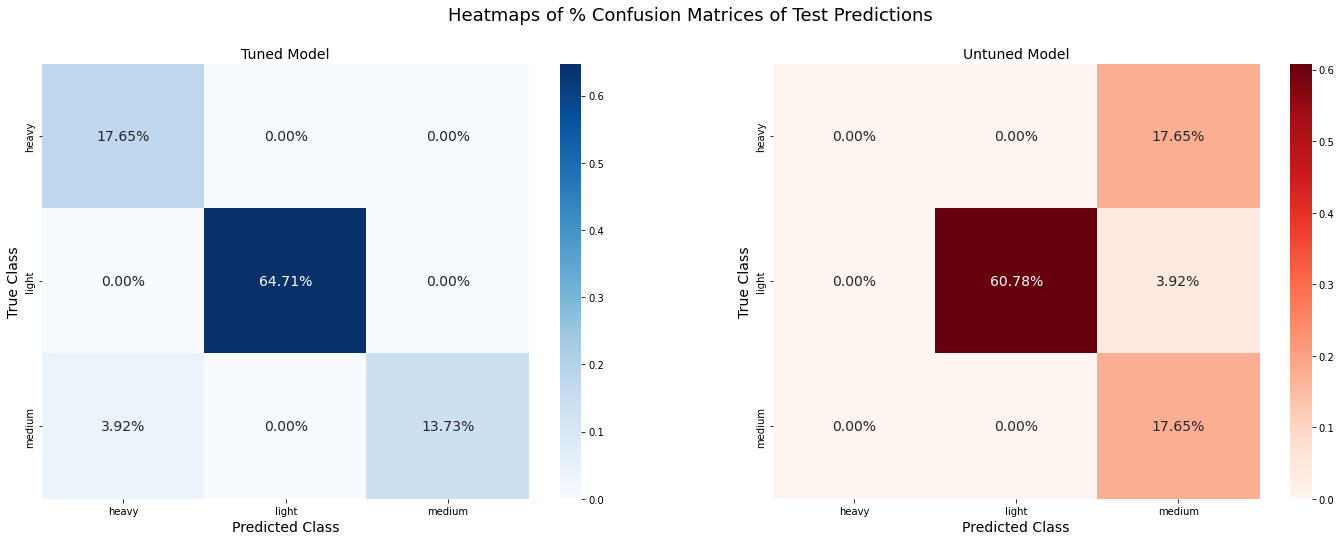

In [ ]:
Plot_Heatmaps(tuned_test_probs, untuned_test_probs)

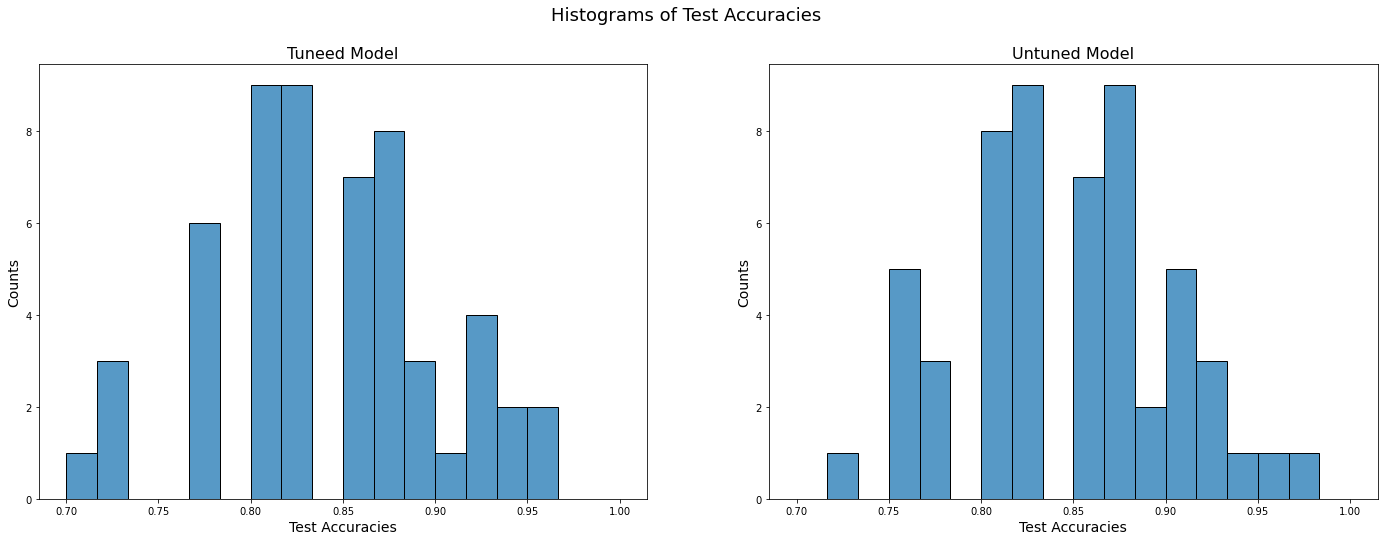

In [ ]:
Compare_TestAcc_Hists(tuned_accs,untuned_accs,'Tuneed Model', 'Untuned Model')

## Testing the tuned models

Still deciding how to interperet results from pretrained and saved models. These models are starting teh kfold training processes having already being trained on some of the data being used in KFold, so I'm not sure if that constitutes leaking or not. If it does, I'm not exactly sure how to effectively kfold these models after saving them, unless there's a way to load them in WITHOUT the weights.

### Tuned model 0
This model performs very well. It seems to be less perfect than *tuned_model_4*, but I'm also less worried about overfitting for this one.

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
tuned_model_name = 'Tuned_model_0.h5'
tuned_model= tf.keras.models.load_model("/content/drive/MyDrive/DATA410_Final_Project/Tuned_Models/" + tuned_model_name)

# Show the model architecture
tuned_model.summary()

_, accuracy = tuned_model.evaluate(test_data, test_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

history, sequence_model, acc = run_experiment(train_data,train_labels,test_data,test_labels, filepath='/content/drive/MyDrive/DATA410_Final_Project/Untuned_Models/best_model_2.hp5')

untuned_test_probs = sequence_model.predict(test_data, batch_size=BATCH_SIZE)
tuned_test_probs = tuned_model.predict(test_data, batch_size=BATCH_SIZE)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 36, 2048)]   0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 36)]         0           []                               
                                                                                                  
 gru_4 (GRU)                    (None, 36, 20)       124200      ['input_5[0][0]',                
                                                                  'input_6[0][0]']                
                                                                                                  
 gru_5 (GRU)                    (None, 10)           960         ['gru_4[0][0]']            

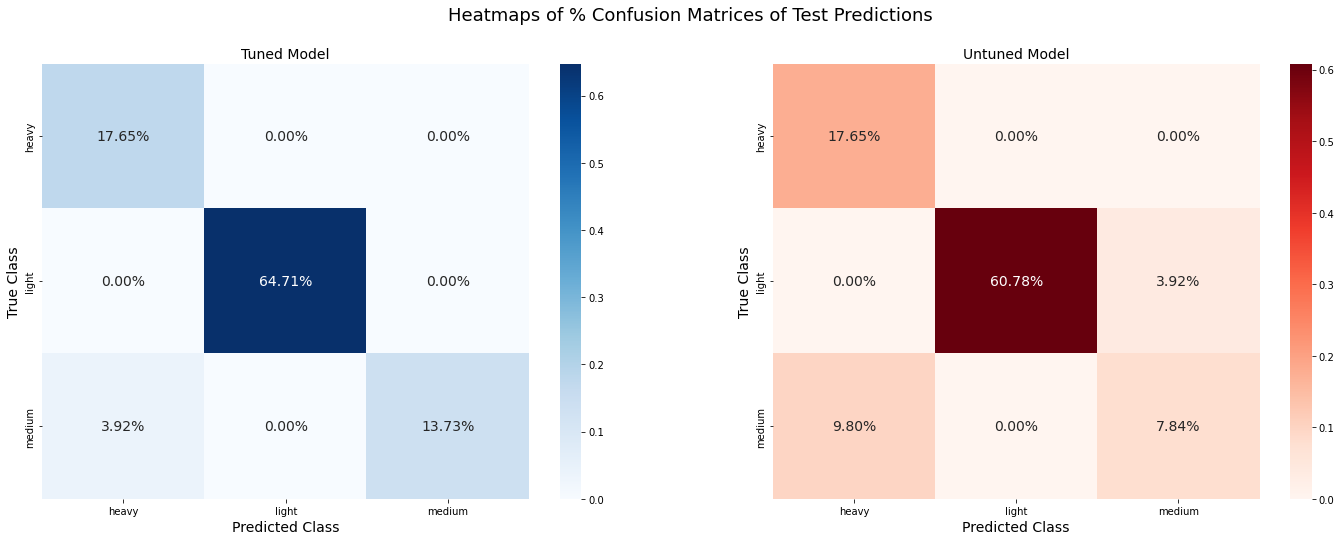

In [ ]:
Plot_Heatmaps(tuned_test_probs,untuned_test_probs)

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold #stratified kfold makes sure each fold is class-balanced

tuned_accs = []
untuned_accs = []
for i in range(12345,12356):
  print('Random State: ' + str(i))
  kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
  # this is the random state cross-validation loop to make sure our results are real
  for idxtrain, idxtest in kf.split(train_data[0], train_labels.flatten()):
    #Split the train and test data
    xtrain = (kfold_data[0][idxtrain],kfold_data[1][idxtrain])
    ytrain = kfold_labels[idxtrain]
    ytest = kfold_labels[idxtest]
    xtest = (kfold_data[0][idxtest],kfold_data[1][idxtest])
    #print('Split Number: ' + str(j))

    # Recreate the hypermodel with the tuned hyperparameters, but now train on the StratifiedKfold data
    hypermodel= tf.keras.models.load_model("/content/drive/MyDrive/DATA410_Final_Project/Tuned_Models/" + tuned_model_name)
    hypermodel.fit(xtrain, ytrain, validation_split=0.2, epochs=25, verbose=0)
    #test the model and append the results
    _, tuned_acc = hypermodel.evaluate(xtest, ytest, verbose=0)

    #Does the same for the un-tuned model
    seq_model = get_sequence_model()
    seq_model.fit(xtrain, ytrain, validation_split=0.2, epochs=EPOCHS, verbose=0)
    _, untuned_acc = seq_model.evaluate(xtest, ytest, verbose=0)


    #Append each accuracy
    tuned_accs.append(tuned_acc)
    untuned_accs.append(untuned_acc)

Random State: 12345
Random State: 12346
Random State: 12347
Random State: 12348
Random State: 12349
Random State: 12350
Random State: 12351
Random State: 12352
Random State: 12353
Random State: 12354
Random State: 12355


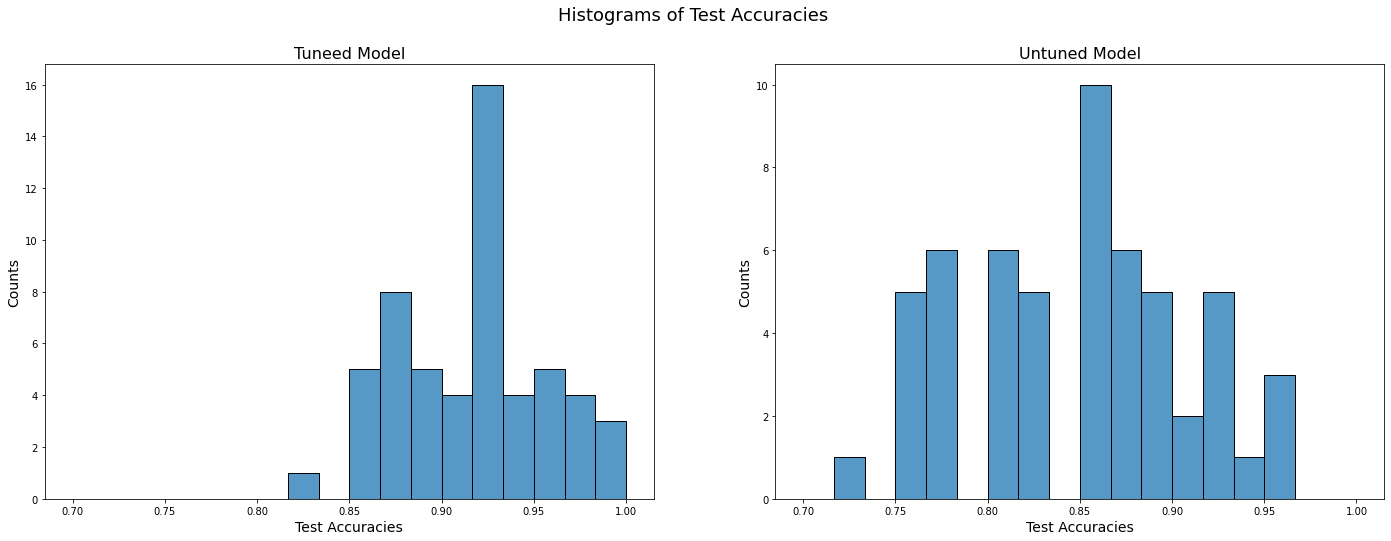

In [ ]:
Compare_TestAcc_Hists(tuned_accs,untuned_accs,'Tuneed Model', 'Untuned Model')

### Tuned Model 4
*tuned_model_4* performs **extremely** well, however this worries me a bit about the potential that it's overfit.



Model: "model_176"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_353 (InputLayer)         [(None, 36, 2048)]   0           []                               
                                                                                                  
 input_354 (InputLayer)         [(None, 36)]         0           []                               
                                                                                                  
 gru_352 (GRU)                  (None, 36, 14)       86688       ['input_353[0][0]',              
                                                                  'input_354[0][0]']              
                                                                                                  
 gru_353 (GRU)                  (None, 12)           1008        ['gru_352[0][0]']        

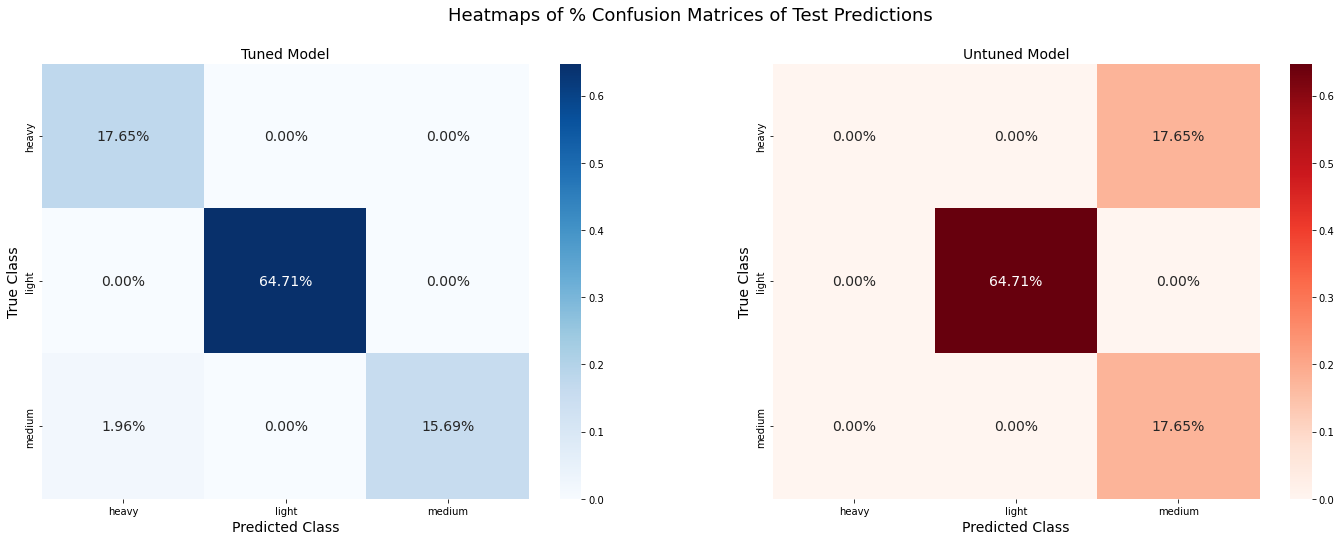

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
tuned_model_name = 'Tuned_model_4.h5'
tuned_model= tf.keras.models.load_model("/content/drive/MyDrive/DATA410_Final_Project/Tuned_Models/" + tuned_model_name)

# Show the model architecture
tuned_model.summary()

_, accuracy = tuned_model.evaluate(test_data, test_labels)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

history, sequence_model, acc = run_experiment(train_data,train_labels,test_data,test_labels, filepath='/content/drive/MyDrive/DATA410_Final_Project/Untuned_Models/best_model_2.hp5')

untuned_test_probs = sequence_model.predict(test_data, batch_size=BATCH_SIZE)
tuned_test_probs = tuned_model.predict(test_data, batch_size=BATCH_SIZE)

Plot_Heatmaps(tuned_test_probs,untuned_test_probs)

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold #stratified kfold makes sure each fold is class-balanced

tuned_accs = []
untuned_accs = []
for i in range(12345,12356):
  print('Random State: ' + str(i))
  kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
  # this is the random state cross-validation loop to make sure our results are real
  for idxtrain, idxtest in kf.split(train_data[0], train_labels.flatten()):
    #Split the train and test data
    xtrain = (kfold_data[0][idxtrain],kfold_data[1][idxtrain])
    ytrain = kfold_labels[idxtrain]
    ytest = kfold_labels[idxtest]
    xtest = (kfold_data[0][idxtest],kfold_data[1][idxtest])
    #print('Split Number: ' + str(j))

    # Recreate the hypermodel with the tuned hyperparameters, but now train on the StratifiedKfold data
    hypermodel= tf.keras.models.load_model("/content/drive/MyDrive/DATA410_Final_Project/Tuned_Models/" + tuned_model_name)
    hypermodel.fit(xtrain, ytrain, validation_split=0.2, epochs=25, verbose=0)
    #test the model and append the results
    _, tuned_acc = hypermodel.evaluate(xtest, ytest, verbose=0)

    #Does the same for the un-tuned model
    seq_model = get_sequence_model()
    seq_model.fit(xtrain, ytrain, validation_split=0.2, epochs=EPOCHS, verbose=0)
    _, untuned_acc = seq_model.evaluate(xtest, ytest, verbose=0)


    #Append each accuracy
    tuned_accs.append(tuned_acc)
    untuned_accs.append(untuned_acc)

Random State: 12345
Random State: 12346
Random State: 12347
Random State: 12348
Random State: 12349
Random State: 12350
Random State: 12351
Random State: 12352
Random State: 12353
Random State: 12354
Random State: 12355


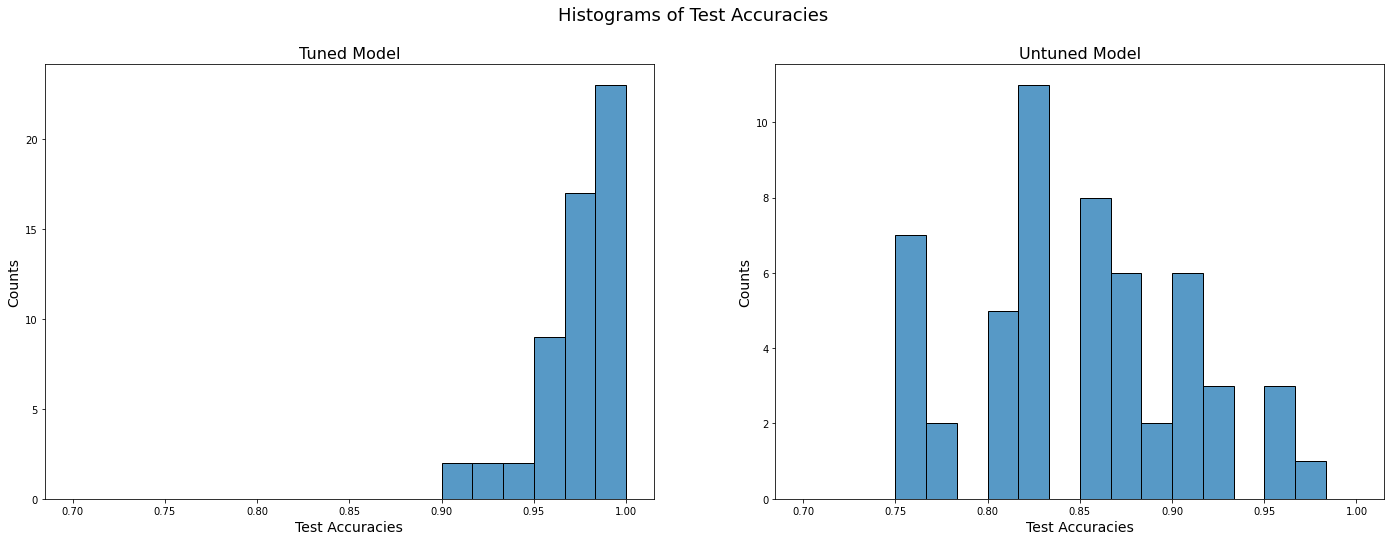

In [ ]:
Compare_TestAcc_Hists(tuned_accs, untuned_accs, 'Tuned Model', 'Untuned Model')

In [ ]:
print('Mean KFold accuracy: ' + str(np.mean(untuned_accs)) + ' and ' + str(np.mean(tuned_accs))) #wooh!
acc_summary = pd.DataFrame({'Tuned': tuned_accs, 'Untuned': untuned_accs})
acc_summary.describe()

Mean KFold accuracy: 0.8453991098837419 and 0.9762860352342779


,Tuned,Untuned
count,55.000000,55.000000
mean,0.976286,0.845399
std,0.025811,0.063638
min,0.902439,0.658537
25%,0.951219,0.804878
50%,0.975610,0.850000
75%,1.000000,0.900000
max,1.000000,0.975000


### Comparing 0 and 4

In [ ]:
accs_0 = []
accs_4 = []
for i in range(12345,12356):
  print('Random State: ' + str(i))
  kf = StratifiedKFold(n_splits=5,shuffle=True,random_state=i)
  # this is the random state cross-validation loop to make sure our results are real
  for idxtrain, idxtest in kf.split(train_data[0], train_labels.flatten()):
    #Split the train and test data
    xtrain = (kfold_data[0][idxtrain],kfold_data[1][idxtrain])
    ytrain = kfold_labels[idxtrain]
    ytest = kfold_labels[idxtest]
    xtest = (kfold_data[0][idxtest],kfold_data[1][idxtest])
    #print('Split Number: ' + str(j))

    #Model 0
    model_0=tf.keras.models.load_model("/content/drive/MyDrive/DATA410_Final_Project/Tuned_Models/Tuned_model_0.h5")
    model_0.fit(xtrain, ytrain, validation_split=0.2, epochs=25, verbose=0)
    #test the model and append the results
    _, acc_0 = model_0.evaluate(xtest, ytest, verbose=0)

    # Model 4
    model_4=tf.keras.models.load_model("/content/drive/MyDrive/DATA410_Final_Project/Tuned_Models/Tuned_model_4.h5")
    model_4.fit(xtrain, ytrain, validation_split=0.2, epochs=25, verbose=0)
    #test the model and append the results
    _, acc_4 = model_4.evaluate(xtest, ytest, verbose=0)


    #Append each accuracy
    accs_0.append(acc_0)
    accs_4.append(acc_4)

Random State: 12345
Random State: 12346
Random State: 12347
Random State: 12348
Random State: 12349
Random State: 12350
Random State: 12351
Random State: 12352
Random State: 12353
Random State: 12354
Random State: 12355


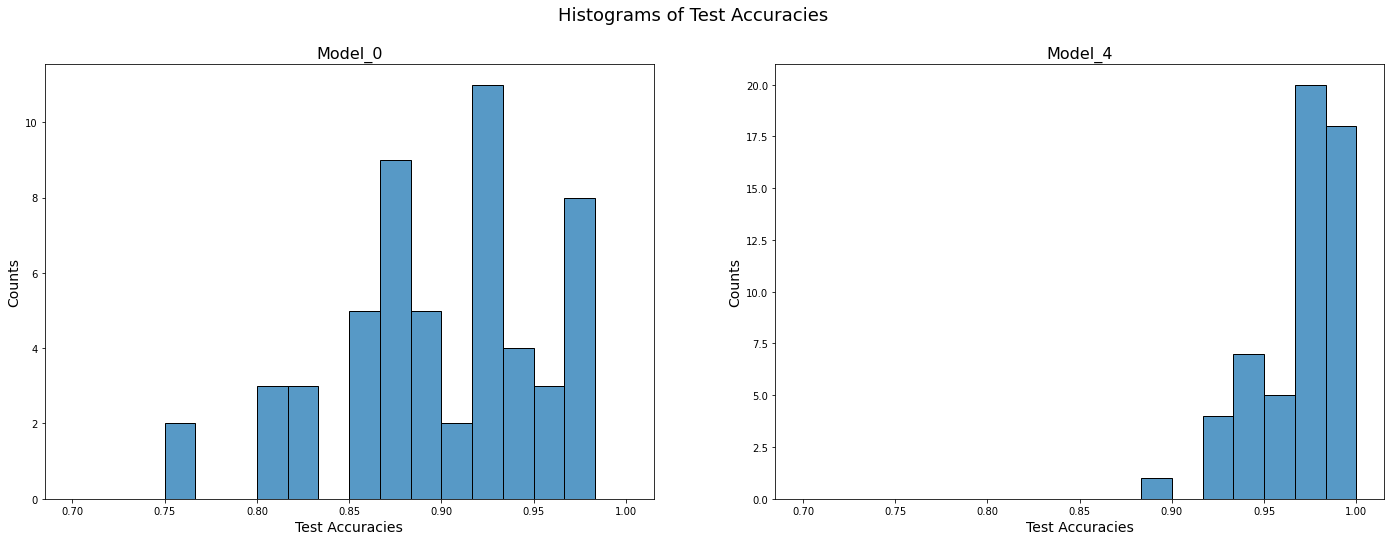

Mean KFold accuracy: 0.8453991098837419 and 0.9762860352342779


,Model_0,Model_4
count,55.000000,55.000000
mean,0.976286,0.845399
std,0.025811,0.063638
min,0.902439,0.658537
25%,0.951219,0.804878
50%,0.975610,0.850000
75%,1.000000,0.900000
max,1.000000,0.975000


In [ ]:
Compare_TestAcc_Hists(accs_0, accs_4, 'Model_0', 'Model_4')

print('Mean KFold accuracy: ' + str(np.mean(untuned_accs)) + ' and ' + str(np.mean(tuned_accs))) #wooh!
acc_summary = pd.DataFrame({'Model_0': tuned_accs, 'Model_4': untuned_accs})
acc_summary.describe()

# Next is trying audio classifcaiton in parallel!
Going to try using CNNs and short-time fourier transform from this notebook: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb

## Import the mini Speech Commands dataset

To save time with data loading, we will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the <a href="https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf" class="external">WAV (Waveform) audio file format</a> of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

Mounted at /content/drive


In [ ]:
#DATASET_PATH = '/content/drive/MyDrive/DATA410_Final_Project/audio/data'


#tf.keras.utils.get_file(
#      'mini_speech_commands.zip',
#      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#      extract=True,
#      cache_subdir=DATASET_PATH)

In [ ]:
DATASET_PATH = '/content/drive/MyDrive/DATA410_Final_Project/audio/data' + "/mini_speech_commands"
data_dir = pathlib.Path(DATASET_PATH)
data_dir

PosixPath('/content/drive/MyDrive/DATA410_Final_Project/audio/data/mini_speech_commands')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['go' 'no' 'left' 'stop' 'up' 'down' 'yes' 'right']


Extract the audio clips into a list called `filenames`, and shuffle it:

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'/content/drive/MyDrive/DATA410_Final_Project/audio/data/mini_speech_commands/stop/4abefdf5_nohash_0.wav', shape=(), dtype=string)


Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:

In [ ]:
# Not using sklearn TTS because of the validation data
# With real data will probably sue TTS with stratify = True
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Read the audio files and their labels
In this section we preprocess teh dataset, creating decoded tensors for the waveforms and the corresponding labels.
Note that:

- Each WAV file contains time-series data with a set number of samples per second.
- Each sample represnets the <a href="https://en.wikipedia.org/wiki/Amplitude" class="external"> amplitude</a> of the audio signal at that specific time.
- In a <a href="https://en.wikipedia.org/wiki/Audio_bit_depth" class="external">16-bit</a> system, like the WAV  files in the mini Speech Commands dataset, the amplitude values range from -32,768 to 32,767.
-The <a href="https://en.wikipedia.org/wiki/Sampling_(signal_processing)#Audio_sampling" class="external">sample rate</a> for this dataset is 16kHz.

The shape of the tensor returned by `tf.audio.decode_wav` is `[samples, channels]`, where `channels` is `1` for mono or `2` for stereo. The mini Speech Commands dataset only contains mono recordings.

In [ ]:
test_file = tf.io.read_file(DATASET_PATH + '/down/0a9f9af7_nohash_0.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([13654, 1])

Define some functions

- `decode_audio` preprocesses raw WAV audio files into audio tensors
- `get_label` creates labels using the parent directories for each file:
  - Split the file paths into `tf.RaggedTensor`'s (tensors with ragged dimensions -- meaning with slices that may have different lengths).
- `get_waveform_and_label` puts it all together. Takes in WAV audio filename and outputs a tuple containing the audio and label tensors ready for supervised learning.

In [ ]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0,1.0] range. Return `float32` audio and a sample rate.
  audio, _ =tf.audio.decode_wav(contents=audio_binary)
  # Since all the mini Speech Commands data is single channel (mono), drop the `channels`
  # axis from the array
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts=tf.strings.split(input=file_path, sep=os.path.sep)
  # Note: Use indexing here instead o tuple unpacking to enable this to work
  # in a Tensorflow graph. (?)
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_b = tf.io.read_file(file_path)
  waveform = decode_audio(audio_b)
  return waveform, label

Now build the training set to extract the audio-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label`.

Later we'll do the same for the test and validation sets.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(map_func=get_waveform_and_label, num_parallel_calls=AUTOTUNE)

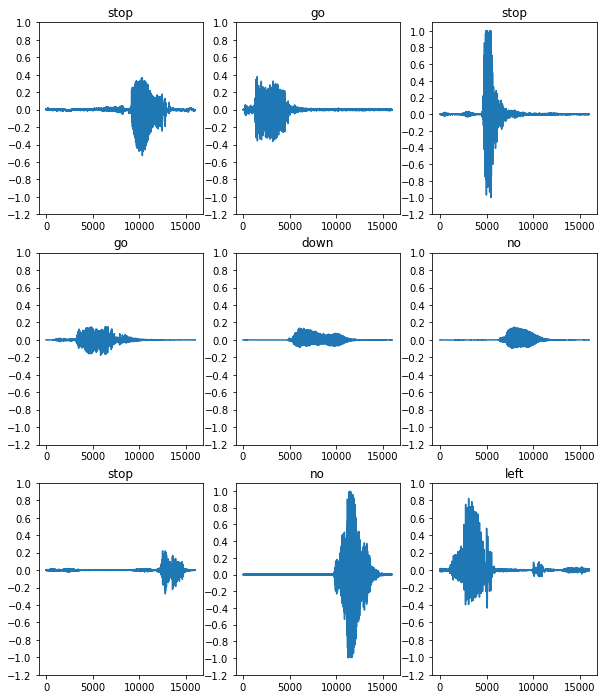

In [ ]:
rows=3
cols=3
n=rows*cols
fig,axes=plt.subplots(rows,cols,figsize=(10,12))

for i, (audio,label) in enumerate(waveform_ds.take(n)):
  r = i//cols
  c = i%cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label=label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Convert waveforms to spectrograms

The waveforms in this dataset are represented in the time doman. Next, we will transform the waaveforms from the time-domain signals into time-frequency doman signals by computing the <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external"> to convert the wavefroms to <a href="https://en.wikipedia.org/wiki/Spectrogram" class='external">spectrograms</a>, which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component requencies, but loses all time information.  In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information and returning a 2D tensor that you can run standard convolutions on.

Now let's create a utility function for converting waveforms into spectrograms. Important notes:

- The waveforms need to  be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more info on the STFT parameters choice, refer to <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">this Coursera video</a> on audio signal processing adn STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, we will only use the magnitude, which can be derived by applying `tf.abs` on the output of `tf.signal.stft`.

In [ ]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples (one second length)
  input_len=16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform), dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the padded waveform to a spectrogram via a STFT
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Now add a `channels` dimension, so that the spectrogram can be used as image-like input data
  # with convolution layers (which expect shape (`batch_size`, `height`, `width`, `channels`))
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Now lets start exploring the data. Lets print the shapes of one examples tensorized waveform and the corresponding spectrogram, and play the original audio:

In [ ]:
for waveform, label in waveform_ds.take(2):
  label=label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label: ', label)
print('Waveform shape: ', waveform.shape)
print('Spectrogram shape: ', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label:  go
Waveform shape:  (16000,)
Spectrogram shape:  (124, 129, 1)
Audio playback


Now define a function for displaying a spectrogram:

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) ==3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns). Add an epsilon to avoid taking the log of any zeros.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Pot the examples waveform over time and the correspnding spectrogram (frequencies over time)

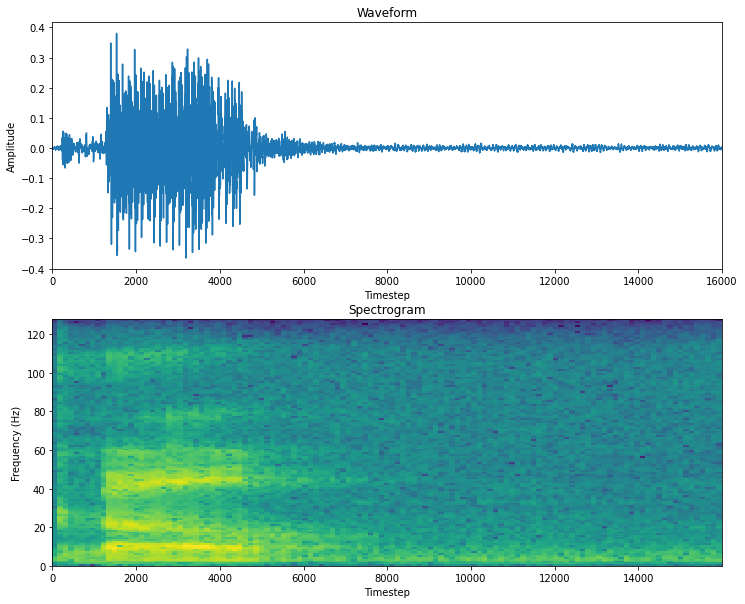

In [ ]:
fig, axes = plt.subplots(2, figsize=(12,10))

timescale=np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0,16000])
axes[0].set_xlabel('Timestep')
axes[0].set_ylabel('Amplitude')

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
axes[1].set_xlabel('Timestep')
axes[1].set_ylabel('Frequency (Hz)')


plt.show()

Now, we define a function that transforms the waveform dataset into spectrograms and their corresponding labels into interger IDs: 

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  commands = np.array(tf.io.gfile.listdir(str(data_dir)))
  commands = commands[commands != 'README.md']

  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

Now map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [ ]:
spectrogram_ds = waveform_ds.map(map_func=get_spectrogram_and_label_id, 
                                 num_parallel_calls=AUTOTUNE)

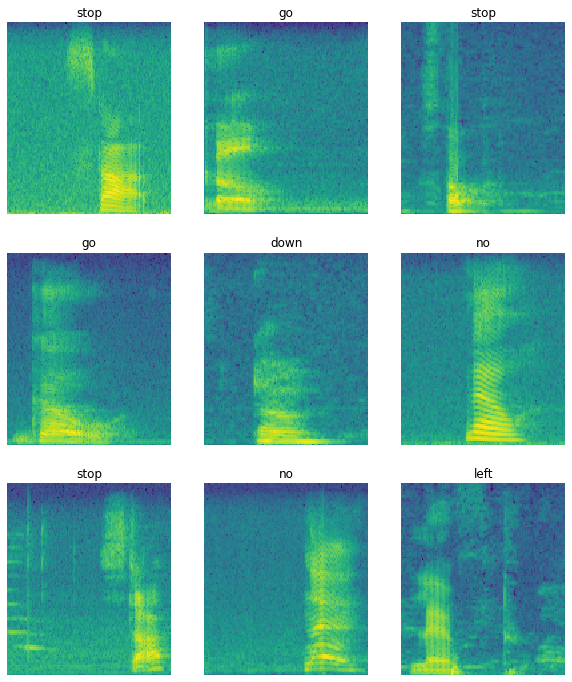

In [ ]:
from numpy.lib.shape_base import column_stack
rows=3
cols=3
n=rows*cols
fig,axes=plt.subplots(rows,cols,figsize=(10,12))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  #print(label_id.numpy()) testing, they are in-fact integers
  r = i//cols
  c = i%cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(),ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

## Now Lets Build and Train a Model!